<a href="https://colab.research.google.com/github/visalya-hub/fmml/blob/main/M2Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 2: Appreciating, Interpreting and Visualizing Data
## Lab 4: t-Distributed Stochastic Neighbor Embedding (t-SNE)







This lab will be based upon t-SNE which is a dimensionality reduction algorithm used to visualize high dimensional datasets.

t-SNE stands for t-Distributed Stochastic Neighbor Embedding. It is an unsupervised, non-linear technique primarily used for data exploration and visualizing high-dimensional data. It was developed by Laurens van der Maatens and Geoffrey Hinton in 2008 (Link to the paper: https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf)

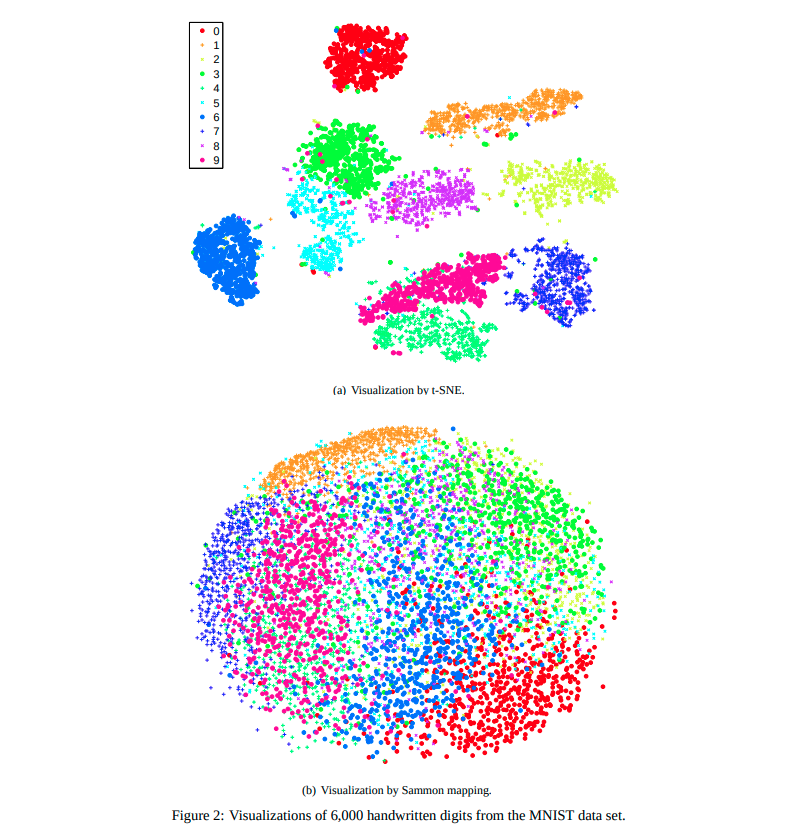

t-SNE has a tuneable parameter, **perplexity** which balances attention between the local and global aspects of your data. It is a guess about the number of close neighbors each point has. The perplexity value has a complex effect on the resulting pictures. The original paper says, “The performance of t-SNE is fairly robust to changes in the perplexity, and typical values are between 5 and 50.” But the story is more nuanced than that. Getting the most from t-SNE may mean analyzing multiple plots with different perplexities.

Also the t-SNE algorithm doesn’t always produce similar output on successive runs as there are additional hyperparameters related to the optimization process.

### HOW DOES T-SNE WORK??

The t-SNE algorithm calculates a similarity measure between pairs of instances in the high dimensional space and in the low dimensional space. It then tries to optimize these two similarity measures using a cost function. Let’s break that down into 3 basic steps.

1. Measure similarities between points in the high dimensional space. Think of a bunch of data points scattered on a 2D space. For each data point (xi) we’ll center a Gaussian distribution over that point. Then we measure the density of all points (xj) under that Gaussian distribution. Then renormalize for all points. This gives us a set of probabilities (Pij) for all points. Those probabilities are proportional to the similarities. All that means is, if data points x1 and x2 have equal values under this gaussian circle then their proportions and similarities are equal and hence you have local similarities in the structure of this high-dimensional space. The Gaussian distribution or circle can be manipulated using what’s called perplexity, which influences the variance of the distribution (circle size) and essentially the number of nearest neighbors.

2. This step is similar to step 1, but instead of using a Gaussian distribution we use a Student t-distribution with one degree of freedom, which is also known as the Cauchy distribution (See fig below). This gives us a second set of probabilities (Qij) in the low dimensional space. As you can see the Student t-distribution has heavier tails than the normal distribution. The heavy tails allow for better modeling of far apart distances.

3. The last step is that we want these set of probabilities from the low-dimensional space (Qij) to reflect those of the high dimensional space (Pij) as best as possible. We want the two map structures to be similar. We measure the difference between the probability distributions of the two-dimensional spaces using Kullback-Liebler divergence (KL). Finally, we use gradient descent to minimize our KL cost function.

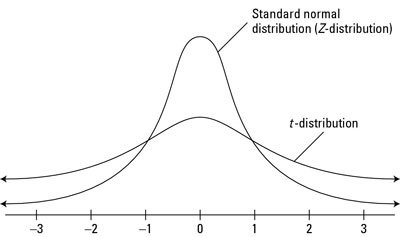

Scikit-learn has an implementation of t-SNE available which provides a wide variety of tuning parameters for t-SNE, and the most notable ones are:

1. n_components (default: 2): Dimension of the embedded space.
2. perplexity (default: 30): The perplexity is related to the number of nearest neighbors that are used in other manifold learning algorithms. Consider selecting a value between 5 and 50.
3. n_iter (default: 1000): Maximum number of iterations for the optimization. Should be at least 250.
4. method (default: ‘barnes_hut’): Barnes-Hut approximation runs in O(NlogN) time. method=’exact’ will run on the slower, but exact, algorithm in O(N^2) time.

In [1]:
# numpy.
import numpy as np
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

# sklearn.
import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

# Random state.
RS = 20150101

# matplotlib.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

# seaborn.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

1797 images each of size 8 x 8 loaded using load_digits()

In [2]:
digits = load_digits()
digits.data.shape

(1797, 64)

Printing some images from the dataset

---



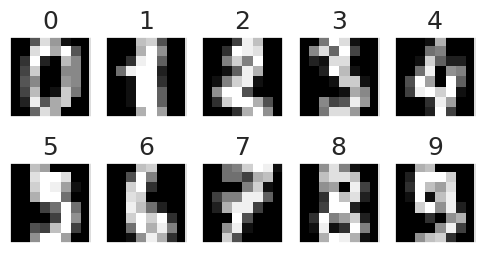

In [3]:
nrows, ncols = 2, 5
plt.figure(figsize=(6,3))
plt.gray()
for i in range(ncols * nrows):
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.matshow(digits.images[i,...])
    plt.xticks([]); plt.yticks([])
    plt.title(digits.target[i])

In [4]:
# We first reorder the data points according to the handwritten numbers.
X = np.vstack([digits.data[digits.target==i]
               for i in range(10)])
y = np.hstack([digits.target[digits.target==i]
               for i in range(10)])

## Now using TSNE to fit the dataset with the default values.


1. n_components : 2
2. perplexity : 30
3. n_iter : 1000
4. method : ‘barnes_hut’


---



In [5]:
digits_proj = TSNE(init="pca", random_state=RS).fit_transform(X)

#### Visualizing the data in the projected space

---



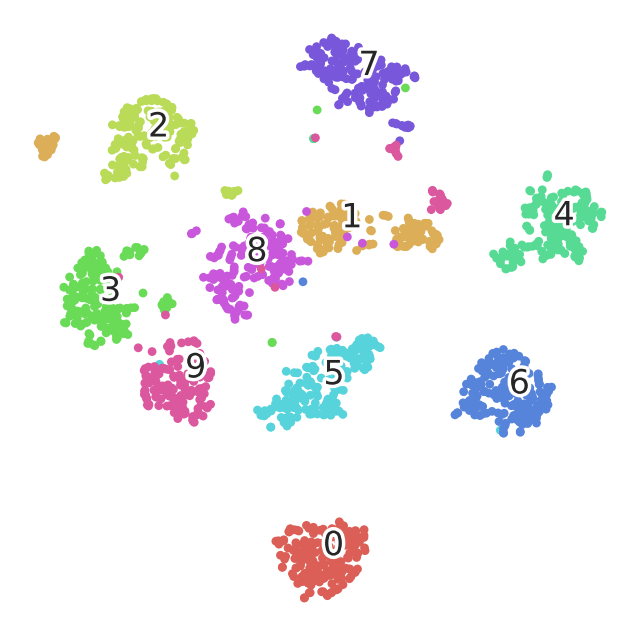

(<Figure size 800x800 with 1 Axes>,
 <Axes: >,
 <matplotlib.collections.PathCollection at 0x788628ec55d0>)

In [6]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
    plt.show()

    return f, ax, sc

scatter(digits_proj, y)

# Tweaking some of the hyperparameters to better understand their role

---

### Changing the PERPLEXITY values


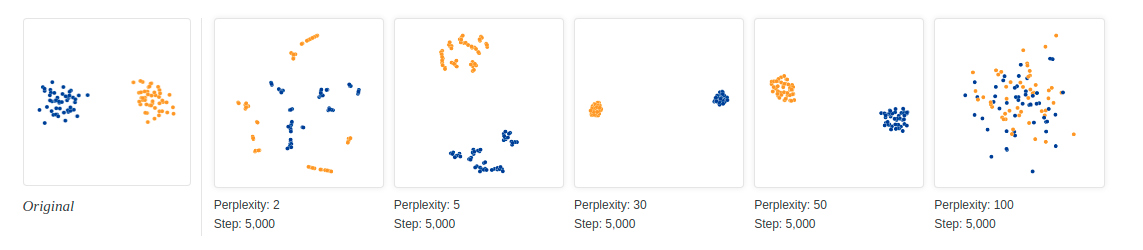

With perplexity values in the range (5 - 50) suggested by van der Maaten & Hinton, the diagrams do show these clusters, although with very different shapes. Outside that range, things get a little weird. With perplexity 2, local variations dominate. The image for perplexity 100, with merged clusters, illustrates a pitfall: for the algorithm to operate properly, the perplexity really should be smaller than the number of points. Implementations can give unexpected behavior otherwise.



---


1. n_components : 2
2. perplexity : **5**
3. n_iter : 1000
4. method : ‘barnes_hut’


---

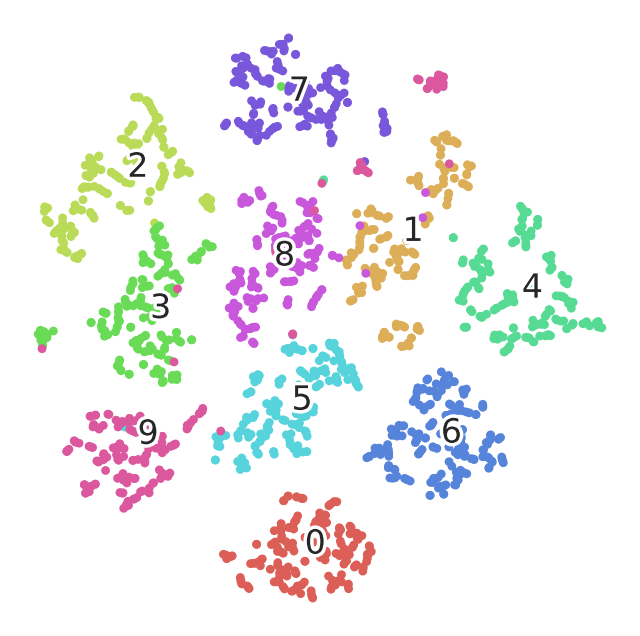

(<Figure size 800x800 with 1 Axes>,
 <Axes: >,
 <matplotlib.collections.PathCollection at 0x788625517590>)

In [7]:
digits_proj = TSNE(init="pca", random_state=RS, perplexity=5).fit_transform(X)

scatter(digits_proj, y)

We can see that there are local clusters within the same number group as well. This is happening as the perplexity being at 5, allows the local neighbourhood to dominate. Let us now see what happens if we increase the perplexity to 100, thereby increasing global impact.





---


1. n_components : 2
2. perplexity : **100**
3. n_iter : 1000
4. method : ‘barnes_hut’


---

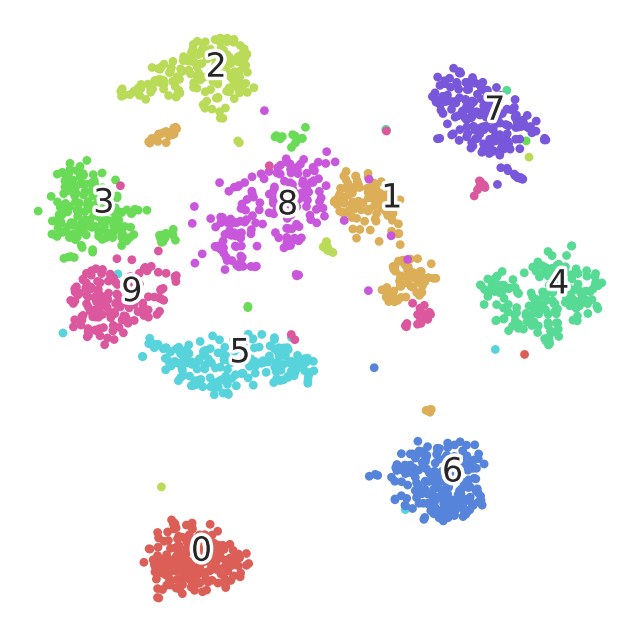

(<Figure size 800x800 with 1 Axes>,
 <Axes: >,
 <matplotlib.collections.PathCollection at 0x788625565e50>)

In [8]:
digits_proj = TSNE(init="pca", random_state=RS, perplexity=100).fit_transform(X)

scatter(digits_proj, y)

The general structure of the plot remained similar to the one with perplexity = 30 (default), but on careful observation you can observe many data points not being part of the group they are supposed to be in. This is because of the large number of points considered for the neighbourhood (as perplexity value = 100 is higher), thereby allowing 2 data points from different groups to end up closer.



---

### Changing the NUMBER OF ITERATIONS

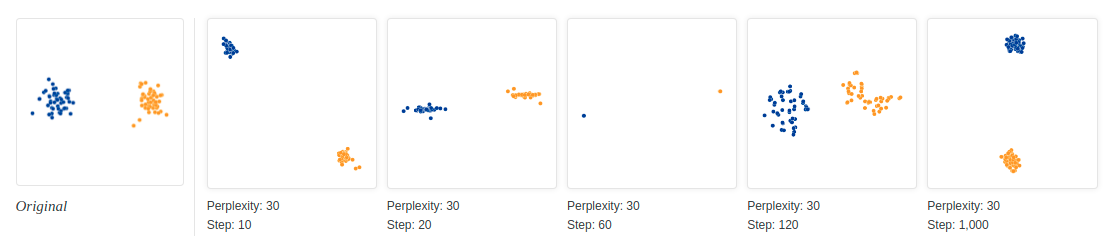

The images above show five different runs at perplexity 30. The first four were stopped before stability. After 10, 20, 60, and 120 steps you can see layouts with seeming 1-dimensional and even pointlike images of the clusters. If you see a t-SNE plot with strange “pinched” shapes, chances are the process was stopped too early. Unfortunately, there’s no fixed number of steps that yields a stable result. Different data sets can require different numbers of iterations to converge.

The most important thing is to iterate until reaching a stable configuration.





---


1. n_components : 2
2. perplexity : 30
3. n_iter : **250**
4. method : ‘barnes_hut’


---

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


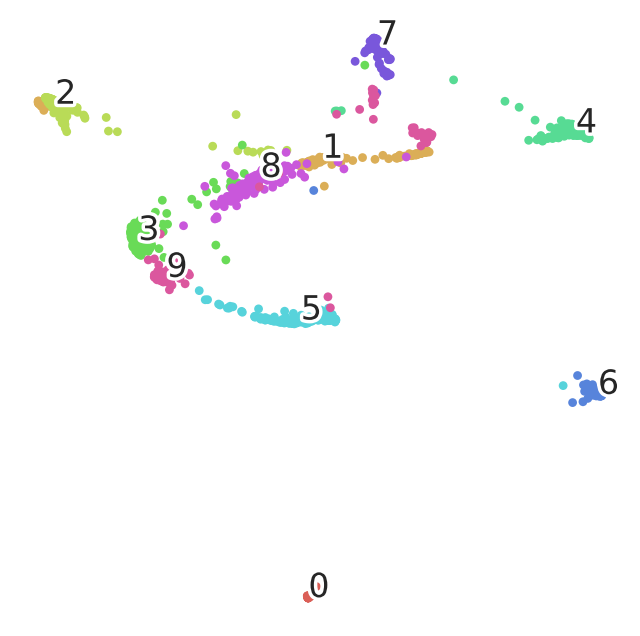

(<Figure size 800x800 with 1 Axes>,
 <Axes: >,
 <matplotlib.collections.PathCollection at 0x7886255d4750>)

In [9]:
digits_proj = TSNE(init="pca", random_state=RS, n_iter=250).fit_transform(X)

scatter(digits_proj, y)

As can be seen from the figure above, stopping the optimization earlier (in 250 iterations) resulted in a suboptimal clustering of the groups.

Let us now see how the results are affected if t-SNE is run for larger number of iterations


---


1. n_components : 2
2. perplexity : 30
3. n_iter : **5000**
4. method : ‘barnes_hut’


---

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


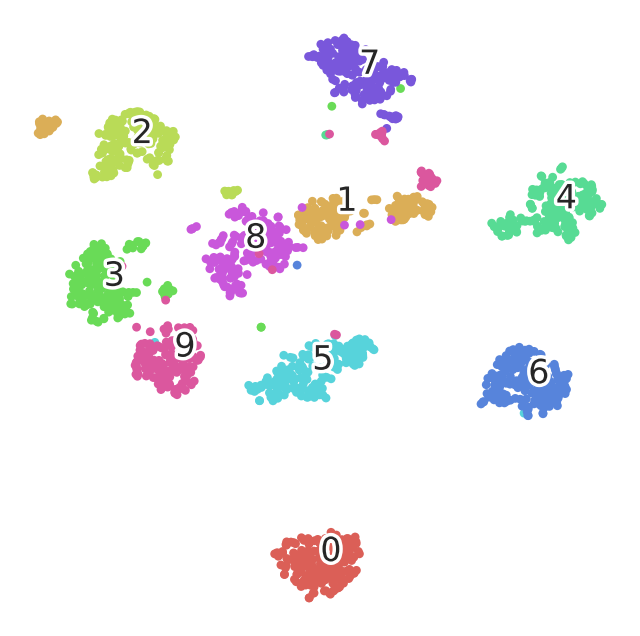

(<Figure size 800x800 with 1 Axes>,
 <Axes: >,
 <matplotlib.collections.PathCollection at 0x788625424590>)

In [10]:
digits_proj = TSNE(init="pca", random_state=RS, n_iter=5000).fit_transform(X)

scatter(digits_proj, y)

Running for larger number of iterations more or less resulted in the same plot as the optimization had nearly converged till the default 1000 iterations. However the density of the clusters has increased.

---

### Changing the method to EXACT

The barnes-hut method takes O(NlogN) time, whereas the exact method takes O(N^2) time. Notice the increase in the execution time while running the cell below.


---

1. n_components : 2
2. perplexity : 30
3. n_iter : 1000
4. method : **‘exact’**


---

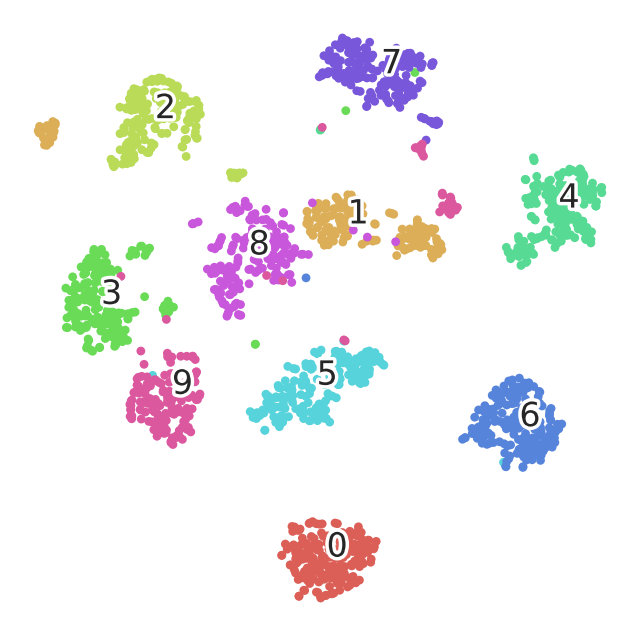

(<Figure size 800x800 with 1 Axes>,
 <Axes: >,
 <matplotlib.collections.PathCollection at 0x78862546b6d0>)

In [11]:
digits_proj = TSNE(init="pca", random_state=RS, method='exact').fit_transform(X)

scatter(digits_proj, y)

## EXERCISE

---



Try out different perplexity and iteration values to better appreciate the concepts taught.

You can modify the code in the cell below to check the resultant plots.

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


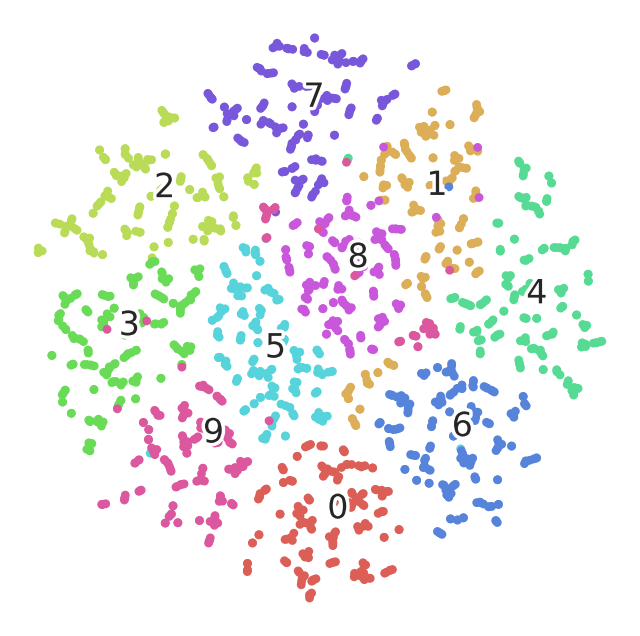

(<Figure size 800x800 with 1 Axes>,
 <Axes: >,
 <matplotlib.collections.PathCollection at 0x7886254bde50>)

In [12]:
###############################################################
###### MODIFY THE VALUES FOR THE HYPERPARAMETERS BELOW ########

perplexity_value = 2
number_iterations = 1000
method = "barnes_hut"

###############################################################

digits_proj = TSNE(init="pca", random_state=RS, n_iter=number_iterations, perplexity=perplexity_value, method=method).fit_transform(X)
scatter(digits_proj, y)

**#Now that you understand t-SNE a bit better, can you point out some differences between PCA and t-SNE.**

**Key differences between PCA and t-SNE:**

* **Linearity:** PCA is a linear algorithm, while t-SNE is non-linear.

* **Preservation:** PCA preserves the global structure of the data, while t-SNE preserves the local neighborhood of the data points.

* **Computational complexity:**PCA is computationally less expensive than t-SNE.

**Advantages of t-SNE over PCA:**

* Captures clusters and manifolds in the data that are not linearly separable.

* Handles non-linear relationships between the data points.

**Disadvantages of t-SNE compared to PCA:**

* Computationally more expensive.
* May not preserve the global structure of the data.


**a. The two algorithms is linear and which one is non-linear :**

**Linearity**

* PCA (Principal Component Analysis) is a linear dimensionality reduction algorithm.
* t-SNE (t-Distributed Stochastic Neighbor Embedding) is a non-linear dimensionality reduction algorithm.

**b.Capturing Complex Data Sets with Non-Linearity :**

**Non-Linearity in t-SNE:** Capturing Complex Data Sets

The non-linearity in t-SNE helps in capturing complex data sets in several ways:

* **Non-linear relationships:**t-SNE can capture non-linear relationships between the data points, which is not possible with PCA. This is particularly useful when the data lies on a manifold that is not linearly separable.

* **Local structure preservation:** t-SNE preserves the local neighborhood of the data points, which means it captures the relationships between nearby points. This is useful when the data has clusters or manifolds that are not linearly separable.

* **Handling high-dimensional data:** t-SNE is particularly useful when dealing with high-dimensional data, where the relationships between the data points are complex and non-linear.

c. **Preserving Distance and Neighborhood in PCA and t-SNE**

PCA and t-SNE have different approaches to preserving distance and **neighborhood in the lower dimension:**

**PCA:** As you mentioned, PCA tends to keep points that were far apart in the higher dimension, far apart in the lower dimension as well. This is because PCA aims to preserve the global structure of the data, focusing on the directions of maximum variance. As a result, PCA can be sensitive to outliers and may not capture local patterns in the data.

**t-SNE:** In contrast, t-SNE focuses on preserving the local neighborhood of the data points, rather than the global structure. t-SNE tries to maintain the proximity of nearby points in the lower dimension, which is useful for capturing clusters, manifolds, and other local patterns in the data. However, this means that t-SNE may not preserve the distances between far-apart points as well as PCA does.

d. **Computational Complexity of PCA and t-SNE**

The computational complexity of PCA and t-SNE differs significantly:

**PCA:** PCA is computationally efficient, with a time complexity of O(n × d × k), where n is the number of data points, d is the number of features, and k is the number of principal components. This is because PCA relies on eigenvalue decomposition, which can be computed efficiently using algorithms like power iteration or QR decomposition.

**t-SNE:** t-SNE, on the other hand, is computationally more expensive, with a time complexity of O(n × log(n) × d), where n is the number of data points and d is the number of features. This is because t-SNE uses a complex optimization process to minimize the KL-divergence between the high-dimensional and low-dimensional distributions, which requires iterative computations and gradient descent.

In general, t-SNE is more computationally expensive than PCA, especially for large datasets. However, the computational cost of t-SNE can be mitigated by using approximate methods, such as Barnes-Hut t-SNE, or by using parallel computing and GPU acceleration.

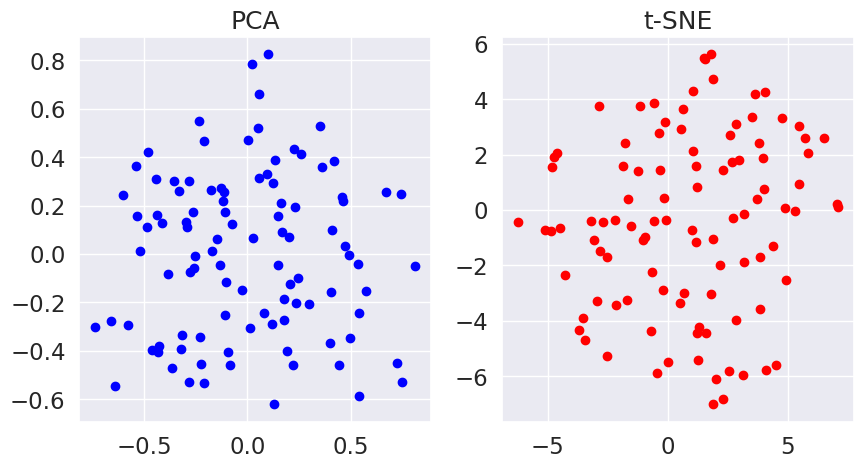

In [13]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Generate a random dataset
X = np.random.rand(100, 10)

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=30)
X_tsne = tsne.fit_transform(X)

# Plot the results
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='blue')
plt.title('PCA')

plt.subplot(1, 2, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c='red')
plt.title('t-SNE')

plt.show()



**#The computational complexity and runtime of t-SNE scale poorly with dataset size and dimensionality. The time complexity of t-SNE is O(N^2) or O(N log N) in the worst case, where N is the number of data points .**

 This is because t-SNE needs to compute the pairwise similarities between all data points, which requires a lot of computations.

In practice, the runtime of t-SNE can be very slow for large datasets. For example, if you have a dataset with 100,000 data points, t-SNE can take several hours or even days to run.

There are some optimized versions of t-SNE, such as MulticoreTSNE and OpenTSNE, which can run faster than the original t-SNE algorithm. However, even with these optimized versions, t-SNE can still be slow for very large datasets.

Here is a rough estimate of the runtime of t-SNE for different dataset sizes:

Small dataset (100-1000 data points): 1-10 seconds

Medium dataset (1000-10,000 data points): 1-10 minutes

Large dataset (10,000-100,000 data points): 1-10 hours

Very large dataset (100,000-1,000,000 data points): 1-10 days

It's worth noting that the runtime of t-SNE also depends on the dimensionality of the data. If the data has a high dimensionality, t-SNE can be slower than if the data has a low dimensionality.

Below is a sample implementation using the scikit-learn library, which provides an efficient implementation of t-SNE. This implementation leverages Barnes-Hut approximations to reduce the computational complexity to
𝑂
(
𝑁
log
⁡
𝑁
)
O(NlogN) per iteration for large datasets.

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
<ipython-input-14-3e6e46656d1e>:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_embedded[:, 0], X_embedded[:, 1], cmap='viridis')


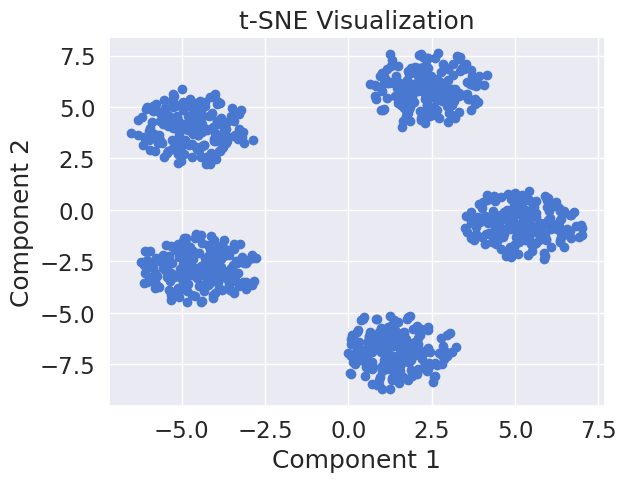

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs

# Generate synthetic data
N = 1000  # Number of points
D = 50    # Dimensionality
X, _ = make_blobs(n_samples=N, n_features=D, centers=5, random_state=42)

# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
X_embedded = tsne.fit_transform(X)

# Plot the results
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], cmap='viridis')
plt.title('t-SNE Visualization')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()


Reducing Computational Complexity
To handle larger datasets and higher dimensions more efficiently, consider the following:

Using Barnes-Hut t-SNE: The method='barnes_hut' option in sklearn.manifold.TSNE is used by default for large datasets. It reduces the complexity to
𝑂
(
𝑁
log
⁡
𝑁
)
O(NlogN).

Subsampling: If the dataset is extremely large, consider using a representative subset of the data for t-SNE.

Dimensionality Reduction Preprocessing: Apply a faster dimensionality reduction technique like PCA before t-SNE to reduce the initial dimensionality
𝐷
D

**#Limitations and Potential Pitfalls of t-SNE**

The limitations and potential pitfalls of using t-SNE include:

**1. Computational Complexity**
t-SNE involves complex calculations as it calculates the pairwise conditional probability for each point, which can be computationally heavy and slow for large datasets.

**2. Non-Determinism**
t-SNE is a non-deterministic algorithm, meaning that it uses random initialization and may produce different results on different runs. This can make it difficult to reproduce results and can lead to inconsistent visualizations.

**3. Hyperparameter Tuning**
t-SNE has several hyperparameters that need to be tuned, such as the perplexity, learning rate, and number of iterations. Finding the optimal values for these hyperparameters can be challenging and may require a significant amount of trial and error.

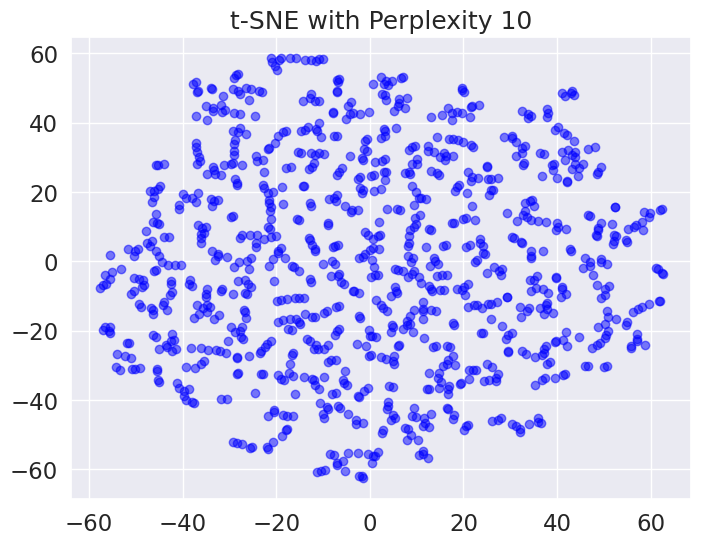

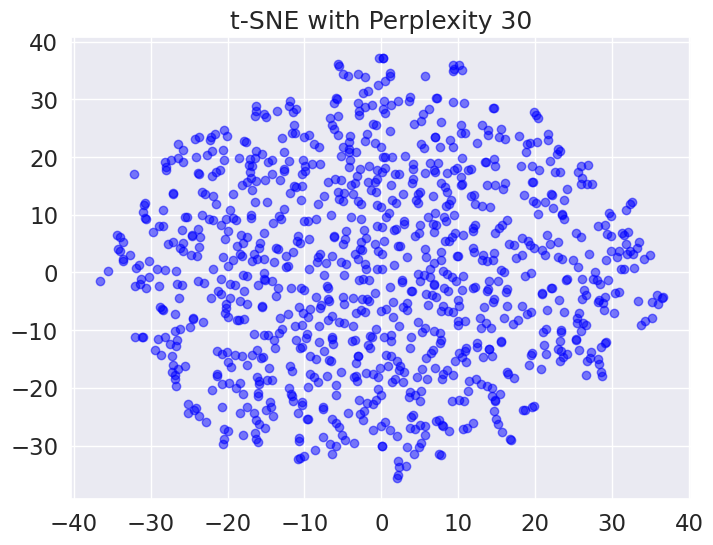

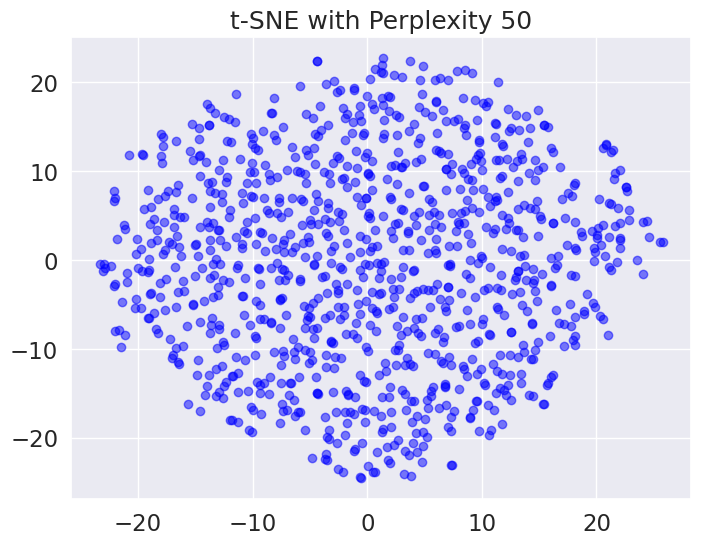

In [15]:
#Visualizing the Effects of Hyperparameter Tuning
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Generate a random dataset with 1000 data points and 10 features
X = np.random.rand(1000, 10)

# Perform t-SNE with different perplexity values
perplexity_values = [10, 30, 50]
for perplexity in perplexity_values:
    tsne = TSNE(n_components=2, perplexity=perplexity)
    X_tsne = tsne.fit_transform(X)

    # Plot the results
    plt.figure(figsize=(8, 6))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c='blue', alpha=0.5)
    plt.title(f"t-SNE with Perplexity {perplexity}")
    plt.show()

This code snippet generates a random dataset and performs t-SNE with different perplexity values. The resulting visualizations are plotted to demonstrate the effects of hyperparameter tuning on the output of t-SNE.



---
 ## Some interesting references:

 1. https://blog.paperspace.com/dimension-reduction-with-t-sne/
 2. https://towardsdatascience.com/an-introduction-to-t-sne-with-python-example-5a3a293108d1
 3. https://distill.pub/2016/misread-tsne/



---


